# Złożoność i wybór modelu

<h1 id=tocheading>Spis treści</h1>
<div id="toc"></div>

In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
import numpy as np
from sklearn.cross_validation import StratifiedKFold, KFold, train_test_split
from sklearn.datasets import load_svmlight_file
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score
from sklearn.metrics import classification_report, matthews_corrcoef, confusion_matrix
from sklearn import preprocessing

In [9]:
from sklearn.datasets import load_boston, load_diabetes, load_linnerud, make_regression, make_s_curve
from sklearn.datasets import make_friedman1, make_friedman2, make_friedman3, make_sparse_uncorrelated
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.cross_validation import cross_val_predict, KFold, StratifiedKFold
from sklearn.utils import resample
from sklearn.metrics import accuracy_score, mean_squared_error

In [5]:
from astroML.datasets import fetch_imaging_sample
from sklearn.preprocessing import PolynomialFeatures
from astroML.cosmology import Cosmology
from astroML.datasets import generate_mu_z

## Błąd testujący i bład uczenia

* __Generalizacja__ określa jak dobrze model będzie sobie radził na danych, których __nie__ widział w trakcie uczenia
  * potrzebujemy metod, które
    1. określać jakość modeli
    * porównywać modele
    * wybierać najlepszy model dla zadanego problemu
      * to dotyczy zarówno typu modelu jak i wyboru parametrów
    * oceniać końcowy błąd wybranego modelu
    * oceniać złożoność modelu
    
    
* __funkcja kosztu__ (__loss function__) jest miarą błędu jaki model popełnia, na przykład funkcja kwadratowa $$L(Y, \hat{f}(X)) = (Y-\hat{f}(X))^2$$
* funkcja $\hat{f}$ została nauczona na danych __trenujących__
  * funkcja kwadratowa jest szeroko używana w zadaniu regresji, ale są dla niego także inne wybory
  * dla klasyfikacji jest wiele innych opcji
  
  
* błąd __testujący__ (albo __generalizacji__) to błąd predykcji (regresji) modelu (nauczonego na zbiorze $\mathcal{T}$) na __ustalonej niależnej__ próbce danych $$Err_\mathcal{T}=E[L(Y, \hat{f}(X))|\mathcal{T}]]$$
* __oczekiwany błąd predykcji__ to $$Err=E[L(Y, \hat{f}(X))]=E[Err_\mathcal{T}]$$
  * to wartość oczekiwana po wszelkich zbiorach uczących (a wobec tego po wszelkich $\hat{f}$) i zbiorach testujących
  * będziemy potrzebowali odpowiedniej procedury by estymować $Err$ i wybrać minimalizujący go model
* błąd __uczenia__ to średni koszt dla zbioru czącego $$err=\frac{1}{N}\sum_i L(Y, \hat{f}(X))$$
  * błąd trenujący __nie jest__ dobrym przybliżeniem błędu predykcji!
  
  
* podobnie dla innych rodzajów błędów
  
   

* typowym problemem jest __brak danych__
  * jesli danych jest bardzo dużo, to można rozdzielić dane na 
    1. __uczące__: dla nauczania
    * __walidujące__: dla wyboru optymalnych parametrów
    * __testujące__: dla sprawdzania błędu generalizacji

## Podział błędu na odchylenie i wariancję (bias-variance decomposition)

* dane pochodzą z procesu pomiaru, są wobec tego obarczone __nieusuwalnym błędem__ $\epsilon$ $$y_i=f(x_i)+\epsilon$$
  * prawdziwa (true) funkcja $f$ jest nieznana
  * o błędzie można założyć, że $E[\epsilon]=0$ oraz $E[\epsilon^2]=\sigma^2$
  
  
* zakładamy, że $L()$ jest __kwadratowa__
$$\begin{align}
Err(x)&=E[L(Y, \hat{f}(X))|X=x]=E[(y-\hat{f}(x))^2]\\
&=E[(f(x)+\epsilon-\hat{f}(x))^2]=E[(f(x)-\hat{f}(x)+\epsilon)^2]\\
&=E[(f(x)-\hat{f}(x))^2]+E[2\epsilon(f(x)-\hat{f}(x))]+E[\epsilon^2]&\text{błąd $\epsilon$ jest nieskorelowany z błędem predykcji}\\
&=E[(f(x)-\hat{f}(x))^2]+E[\epsilon^2]\\
\\
&=E\left[\left(f(x)-E[\hat{f}(x)]+E[\hat{f}(x)]-\hat{f}(x)\right)^2\right]+E\left[\epsilon^2\right]\\
\\
&=E\left[\left(f(x)-E[\hat{f}(x)]\right)^2\right]\\
&+E\left[\left(f(x)-E[\hat{f}(x)]\right)\left(E[\hat{f}(x)]-\hat{f}(x)\right)\right]&\text{błedy są znowu nieskorelowane}\\
&+E\left[\left(E[\hat{f}(x)]-\hat{f}(x)\right)^2\right]+E\left[\epsilon^2\right]\\
\\
&=\underbrace{E\left[\left(f(x)-E[\hat{f}(x)]\right)^2\right]}_{\text{bias}^2}
+\underbrace{E\left[\left(E[\hat{f}(x)]-\hat{f}(x)\right)^2\right]}_{\text{wariancja modelu}}
+\underbrace{E\left[\epsilon^2\right]}_{\text{szum danych}}
\end{align}$$

* __bias$^2$__: to suma kwadratów różnic między wartością prawdziwej (ale nieznanej) funkcji $f()$ a wartością oczekiwaną estymacji,
* __wariancja modelu__: (czasem __błąd estymacji__) używając różnych zbiorów uczących, różnych parametrów modelu, różnych punktów startu (w algorytmach iteracyjnych) możemy dostać różne dofitowania modelu, a stąd modele będą miały pewną wariancję wokół wartości średniej
* __szum danych__: jest niezależny od procesu uczenia; zwykle jest to biały szum



* rozkład błędu pozwala na wyciągnięcie wniosków o uczeniu
  * oczekujemy, że model bedzie __maksymalnie prosty__
    * wtedy jednak możliwy jest wysoki bias, gdy model jest __prostszy__ od rzeczywistych danych (estymacja wielomiany prostą)
    * bias można zredukować przez zwiększenie przestrzeni dostępnych funkcji
    * modele w których bias przeważa często "__underfitują__"
      * zwykle na początku uczenia model jest zwykle bardzo prosty, ma duzy błąd a bias przeważa nad wariancję
  * jednocześnie chcemy, by model dobrze się __dostosowywał__
    * wtedy może mieć wysoką wariancję
      * podczas procesu uczenia  model coraz lepiej dostosowuje się, bias i błąd spadają
      * błąd dla zbioru trenującego stale maleje
      * jednak wariancja (dla różnych modeli) zaczyna wzrastać i nie ma pewności czy model bedzie dobrze generalizował
      * modele z przewagą wariancji często "__przefitowują__"
      * modele z ograniczoną przestrzenią funkcji (np. ridge, lasso) dają niską wariancję
  * rozwiązania?
    * uczenie należy przerwać wcześniej nim osiągnie minimalny błąd
      * metoda wczesnego zatrzymywania (early stopping)
      * kontrola za pomocą zbioru walidacyjnego
      * metoda walidacji krzyżowej
    



* analogiczne rozumowanie dla innych funkcji kosztu nie jest oczywiste
  * Domingos zaproponował ostatnio rozwinięcie do 

In [188]:
from itertools import combinations

In [231]:
def bootstrap_linear_approximations(models=10, n_samples=100, noise=0.5):
    X = np.random.uniform(-5, +5, [n_samples, 1])
    #X = np.linspace(-5, 5, 100).reshape((100, 1))
    t0 = 0.25; t1 = 0.02; t2 = 0.04; t3 = 0.04
    y_true =  (0.25 + t1 * X + t2 * X**2 + t3 * X**3).reshape((n_samples,))
    if noise > 0.:
        y = y_true + np.random.normal(scale=noise, size=len(y_true))
    else:
        y = y_true
    #print 'X.shape = {}, y_true.shape = {}, y.shape = {}'.format(X.shape, y_true.shape, y.shape)
    #print X
    #print y_true
    #print y
    y_noise = np.sum((y - y_true) ** 2) / n_samples
    
    fig, ax = plt.subplots(figsize=(18, 8))
    xmin, xmax = min(X), max(X)
    ymin, ymax = min(y), max(y)
    x_range = np.linspace(xmin, xmax, 100)
    ax.plot(X, y, 'r*')
    ax.plot(X, y_true, 'g*')
    ax.grid()
    #ax.plot(x_range, x_range * theta_data[1] + theta_data[0], 'k-')
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    
    theta = np.zeros((models, 2))
    predicted_all = np.zeros((models, len(y)))
    #print np.mean(y)
    print '\tnoise\t  variance\t  bias\t\t  mse\n{}'.format('-' * 70)
    for k in range(models):
        X_train, y_train = resample(X, y)
        clr = LinearRegression()
        clr.fit(X_train, y_train)
        predicted = clr.predict(X)
        predicted_all[k, :] = predicted
        theta_fit = [np.mean(predicted), clr.coef_]
        ax.plot(x_range, x_range * theta_fit[1] + theta_fit[0], lw=1)
        theta[k, :] = theta_fit
        y_fit_mean = np.mean(predicted)
        var = np.sum((y - y_fit_mean) ** 2) / n_samples
        bias_squared = np.sum((y_true - y_fit_mean) ** 2) / n_samples
        mse = y_noise + var + bias_squared
        err = np.sum((y - predicted) ** 2) / n_samples
        #print '{}: \t{}\t+ {}\t+ {}\t= {}'.format(k, np.round(y_noise, 4), np.round(var, 4), 
        #                                             np.round(bias_squared, 4), np.round(mse, 4))
        
    theta_mean = np.mean(theta, 0)
    ax.plot(x_range, x_range * theta_mean[1] + theta_mean[0], 'k-', lw=5)
    # teraz licze oczekiwana wartosc obliczonej funkcji
    y_ens_fit = np.mean(predicted_all, 0)
    y_ens_fit_mean = np.mean(y_ens_fit)
    var = 0
    for m in range(models):
        var = np.sum((y_ens_fit - predicted_all[m, ]) ** 2)
    var /=  models * n_samples ** 2
    # var = np.sum((y_ens_fit - y_ens_fit_mean) ** 2) / (n_samples ** 2)
    bias_squared = np.sum((y_true - y_ens_fit) ** 2) / n_samples
    mse = y_noise + var + bias_squared
    err = np.sum((y_true - y_ens_fit) ** 2) / n_samples
    print '{}: \t{}\t+ {}\t+ {}\t= {}'.format('ens', np.round(y_noise, 4), np.round(var, 4), 
                                                  np.round(bias_squared, 4), np.round(mse, 4))
    
    compute_ensembles = True
    if compute_ensembles:
        max_models = 100
        for k in range(1, models):
            comb = [c for c in combinations(range(models), k)]
            # select max_models indices
            ind = list(np.random.choice(len(comb), max(max_models, len(comb))))
            var_ens = 0
            bias_squared_ens = 0
            mse_ens = 0
            for q in ind:
                p = comb[q]
                y_ens_fit = np.mean(predicted_all[p, ], 0)
                y_ens_fit_mean = np.mean(y_ens_fit)
                var = 0
                for m in p:
                    var = np.sum((y_ens_fit - predicted_all[m, ]) ** 2)
                var /=  len(p) * n_samples ** 2
                var_ens += var / len(p)
                bias_squared = np.sum((y_true - y_ens_fit) ** 2) / n_samples
                bias_squared_ens += bias_squared / len(p)
            var_ens /= len(ind)
            bias_squared_ens /= len(ind)
            mse = y_noise + var_ens + bias_squared_ens
            print '{}:{}: \t{}\t+ {}\t+ {}\t= {}'.format('e', k, np.round(y_noise, 4), np.round(var_ens, 4), 
                                                              np.round(bias_squared_ens, 4), np.round(mse, 4))
    

	noise	  variance	  bias		  mse
----------------------------------------------------------------------
ens: 	1.7887	+ 0.0008	+ 0.5171	= 2.3066
e:1: 	1.7887	+ 0.0	+ 0.6943	= 2.483
e:2: 	1.7887	+ 0.0007	+ 0.2951	= 2.0844
e:3: 	1.7887	+ 0.0004	+ 0.1875	= 1.9765
e:4: 	1.7887	+ 0.0002	+ 0.1369	= 1.9258
e:5: 	1.7887	+ 0.0002	+ 0.1077	= 1.8965
e:6: 	1.7887	+ 0.0002	+ 0.0885	= 1.8774
e:7: 	1.7887	+ 0.0001	+ 0.076	= 1.8648
e:8: 	1.7887	+ 0.0001	+ 0.0658	= 1.8546
e:9: 	1.7887	+ 0.0001	+ 0.0575	= 1.8463


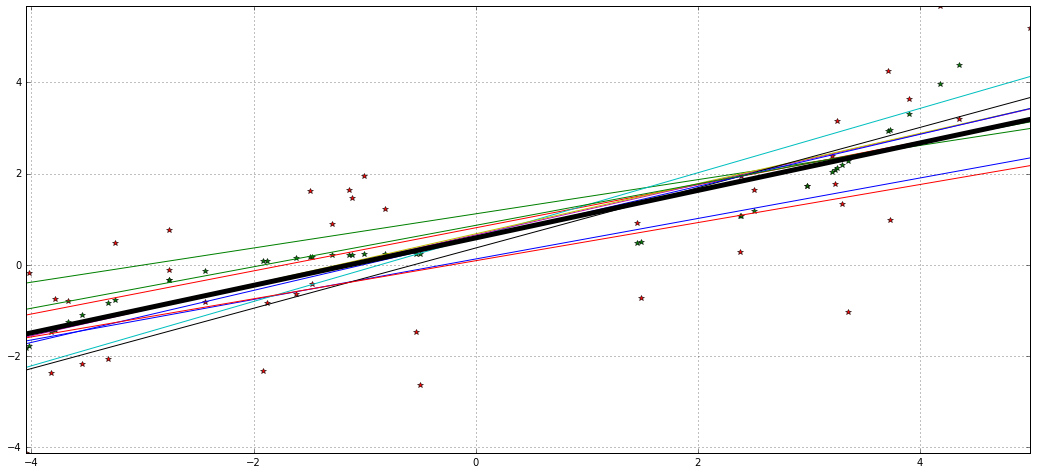

In [232]:
bootstrap_linear_approximations(models=10, n_samples=40, noise=1.5)

In [167]:
from itertools import combinations

In [173]:
[c for c in combinations(range(5), 3)]

[(0, 1, 2),
 (0, 1, 3),
 (0, 1, 4),
 (0, 2, 3),
 (0, 2, 4),
 (0, 3, 4),
 (1, 2, 3),
 (1, 2, 4),
 (1, 3, 4),
 (2, 3, 4)]

In [174]:
x = np.array(range(10)).reshape((5, 2))

In [176]:
x

array([[0, 1],
       [2, 3],
       [4, 5],
       [6, 7],
       [8, 9]])

In [192]:
np.mean(x[[0, 2, 4, 3],], axis=0)

array([ 4.5,  5.5])

In [202]:
list(np.random.choice(len(x), 3, replace=False))

[1, 4, 3]